In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate
from sklearn.metrics import ConfusionMatrixDisplay

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_feature = 'PctFam2Par'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['PctFam2Par_bin'] = pd.cut(data['PctFam2Par'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)
y_pred_binary = (y_pred > threshold).astype(int)

# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Compute metrics for different groups
metrics = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)


Overall Metrics:
{'accuracy': 0.27472527472527475, 'precision': 0.27472527472527475, 'recall': 1.0, 'f1': 0.43103448275862066}

Metrics by Sensitive Feature Groups:
PctFam2Par_bin
0    {'accuracy': 0.4, 'precision': 0.4, 'recall': ...
1    {'accuracy': 0.5833333333333334, 'precision': ...
2    {'accuracy': 0.37037037037037035, 'precision':...
3    {'accuracy': 0.2, 'precision': 0.2, 'recall': ...
4    {'accuracy': 0.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


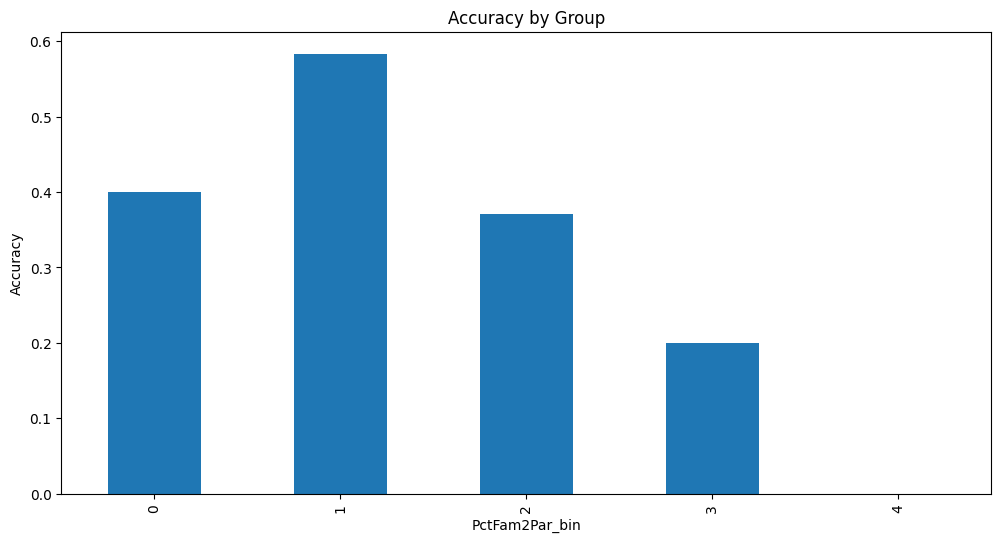

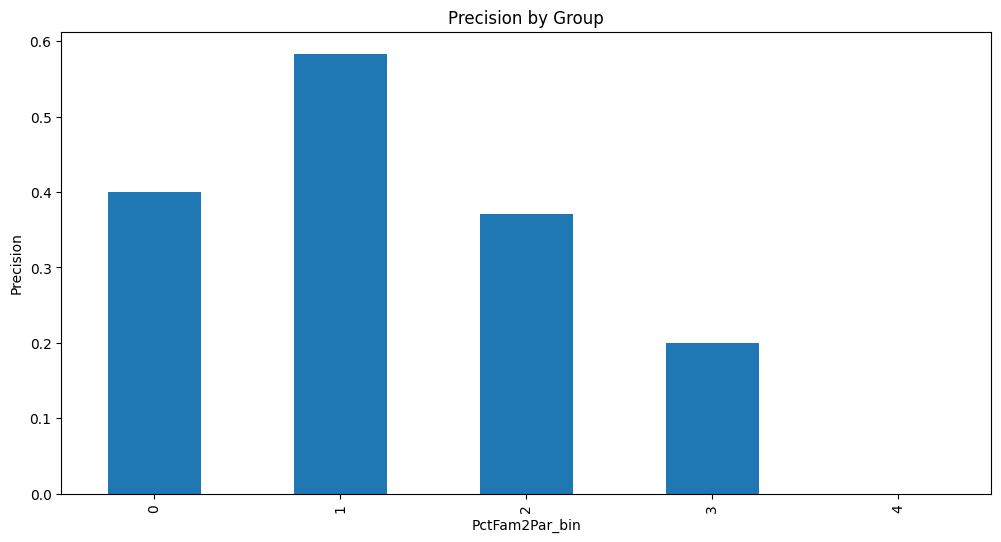

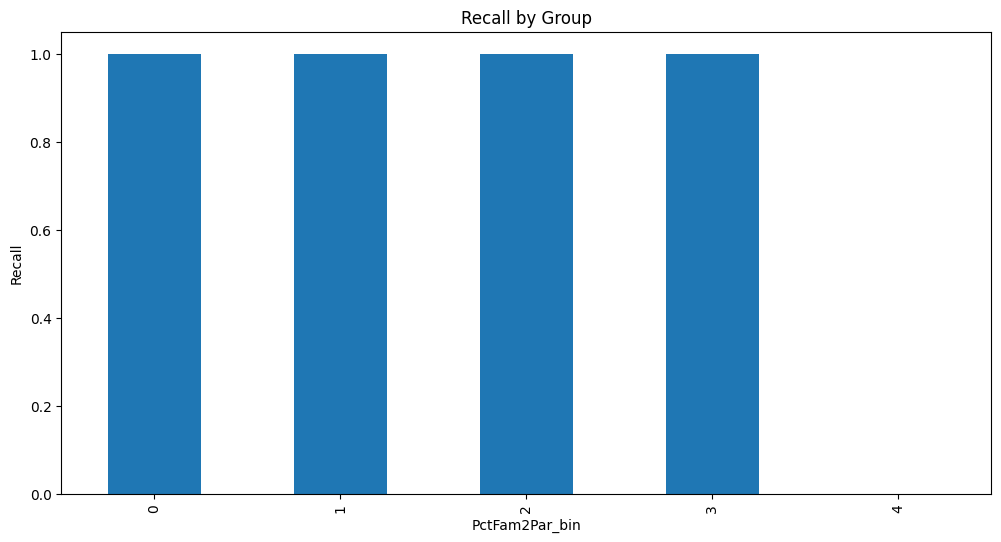

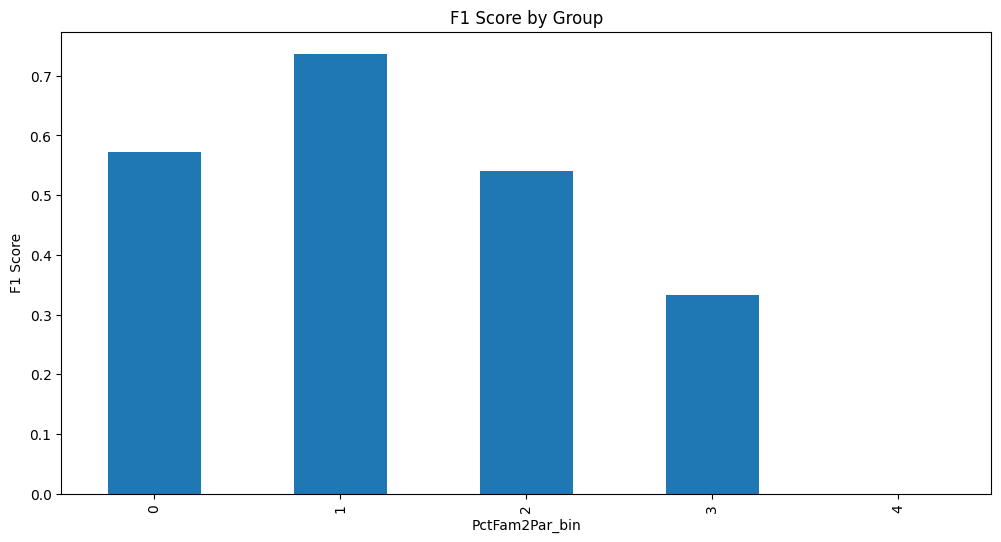

In [3]:
# Extract metrics for visualization
metrics_by_group = metrics.by_group.apply(pd.Series)
accuracy = metrics_by_group['accuracy']
precision = metrics_by_group['precision']
recall = metrics_by_group['recall']
f1 = metrics_by_group['f1']

# Plot Accuracy by Group
accuracy.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group
precision.plot(kind='bar', figsize=(12, 6), title='Precision by Group')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group
recall.plot(kind='bar', figsize=(12, 6), title='Recall by Group')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group
f1.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group')
plt.ylabel('F1 Score')
plt.show()


In [4]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [5]:
# Calculate fairness metrics
dpd = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
eod = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
fprd = false_positive_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
srd = selection_rate_difference(y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")


Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.0
False Negative Rate Difference: nan
Selection Rate Difference: 0.0
False Omission Rate Difference: nan
True Negative Rate Difference: 0.0


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3481796832.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_PctFam2Par = df.groupby('PctFam2Par_bin').apply(lambda x: pd.Series({



Additional Metrics by 'PctFam2Par_bin':
                accuracy  precision  recall        f1
PctFam2Par_bin                                       
0               0.400000   0.400000     1.0  0.571429
1               0.583333   0.583333     1.0  0.736842
2               0.370370   0.370370     1.0  0.540541
3               0.200000   0.200000     1.0  0.333333
4               0.000000   0.000000     0.0  0.000000


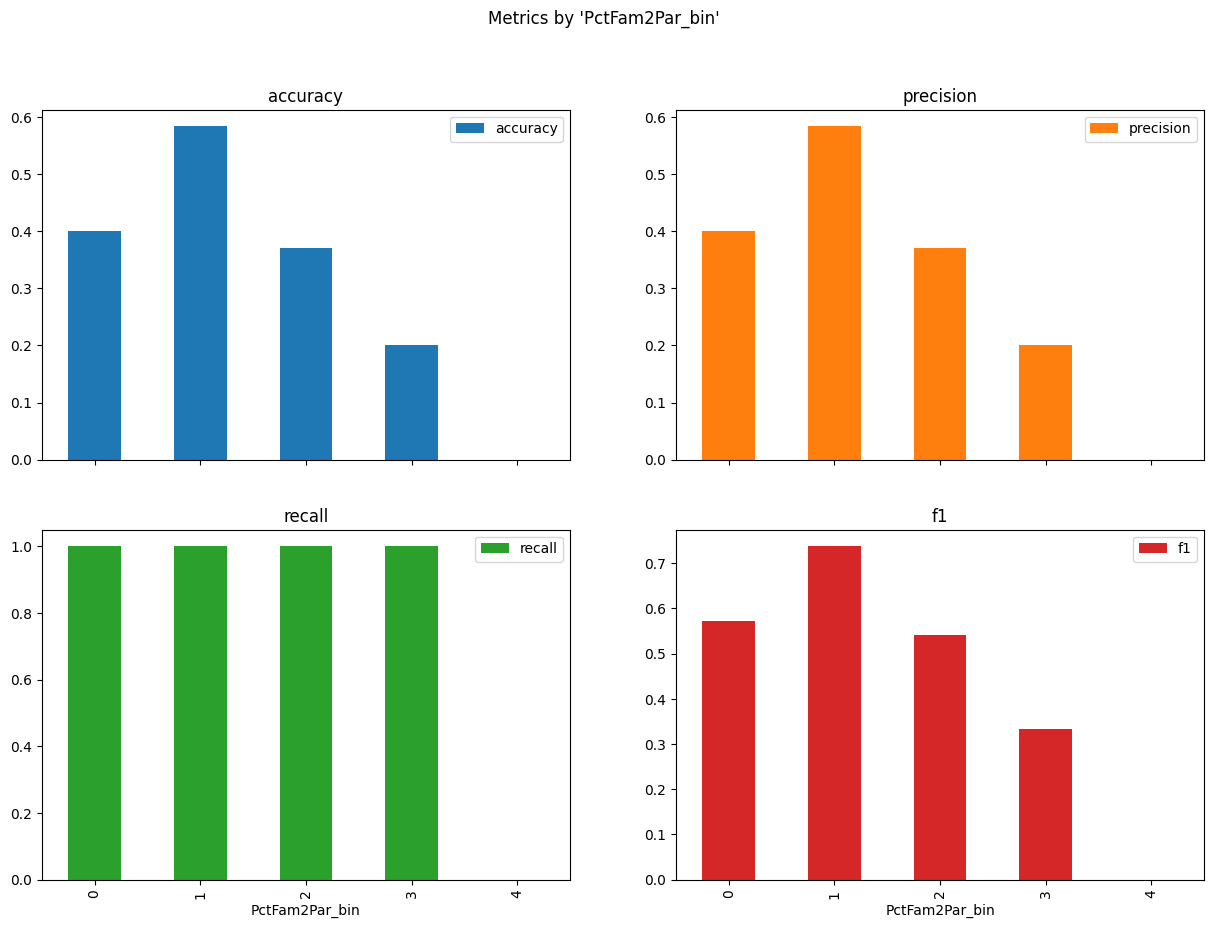

C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tn)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_14332\3047860701.py


Additional Metrics by Sensitive Feature Groups:
                false_positive_rate  false_negative_rate  false_omission_rate  \
PctFam2Par_bin                                                                  
0                               1.0                  0.0                  NaN   
1                               1.0                  0.0                  NaN   
2                               1.0                  0.0                  NaN   
3                               1.0                  0.0                  NaN   
4                               1.0                  NaN                  NaN   

                true_negative_rate  
PctFam2Par_bin                      
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  


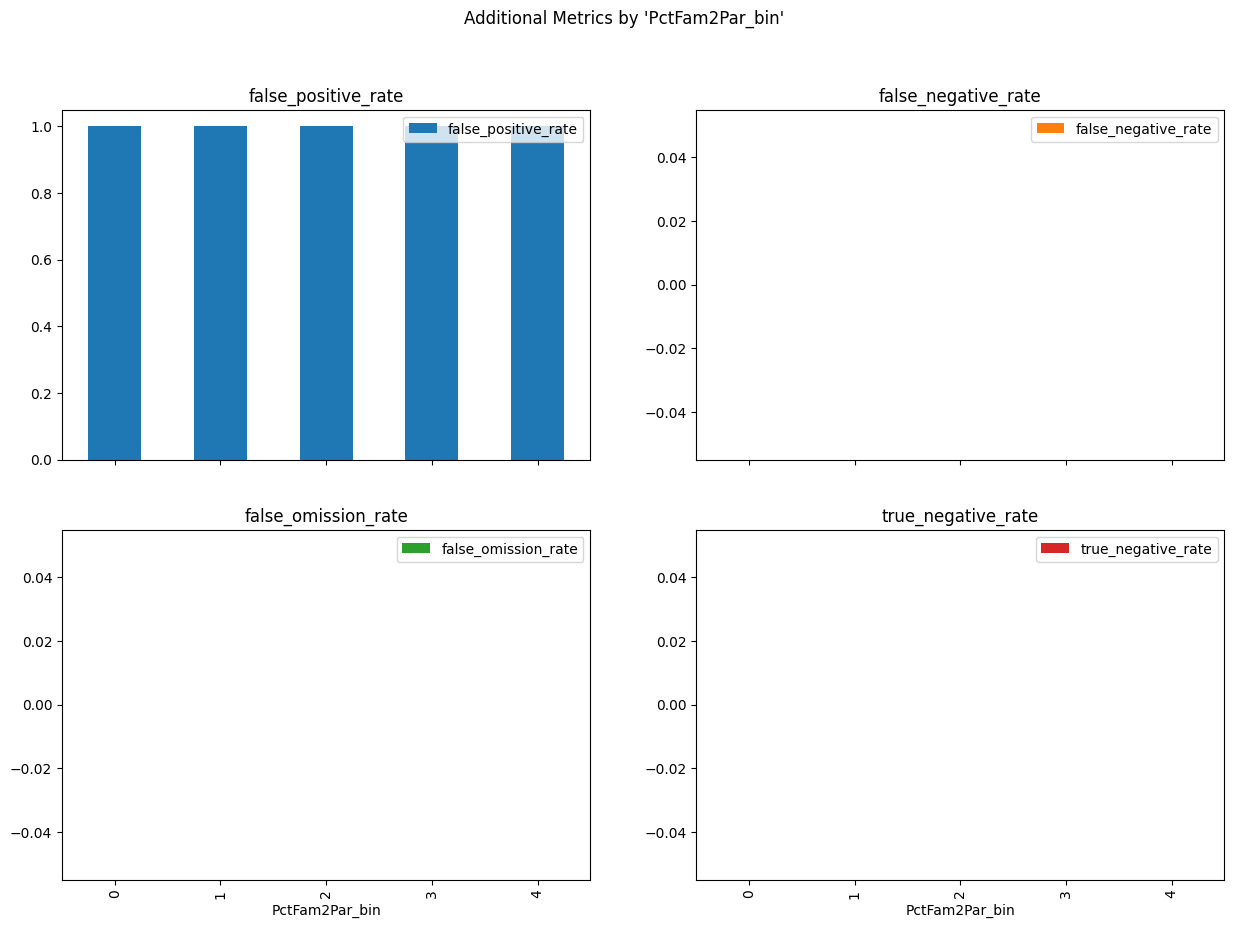

In [6]:
# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_binary,
    'PctFam2Par_bin': data.loc[X_test.index, 'PctFam2Par_bin']
})

# Calculate additional metrics for each subgroup
grouped_PctFam2Par = df.groupby('PctFam2Par_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['y_true'], x['y_pred']),
    'precision': precision_score(x['y_true'], x['y_pred'], zero_division=0),
    'recall': recall_score(x['y_true'], x['y_pred'], zero_division=0),
    'f1': f1_score(x['y_true'], x['y_pred'], zero_division=0)
}))

print("\nAdditional Metrics by 'PctFam2Par_bin':")
print(grouped_PctFam2Par)

# Plot additional metrics by 'PctFam2Par_bin'
grouped_PctFam2Par.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'PctFam2Par_bin'")
plt.show()

# Calculate additional fairness metrics
for_custom_metrics = {
    'false_positive_rate': false_positive_rate_custom,
    'false_negative_rate': false_negative_rate_custom,
    'false_omission_rate': false_omission_rate_custom,
    'true_negative_rate': true_negative_rate_custom
}

additional_metrics = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print additional metrics by group
print("\nAdditional Metrics by Sensitive Feature Groups:")
print(additional_metrics.by_group)

# Plot additional metrics
additional_metrics.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'PctFam2Par_bin'")
plt.show()



Summary of Fairness Metrics:
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.0
False Negative Rate Difference: nan
Selection Rate Difference: 0.0
False Omission Rate Difference: nan
True Negative Rate Difference: 0.0


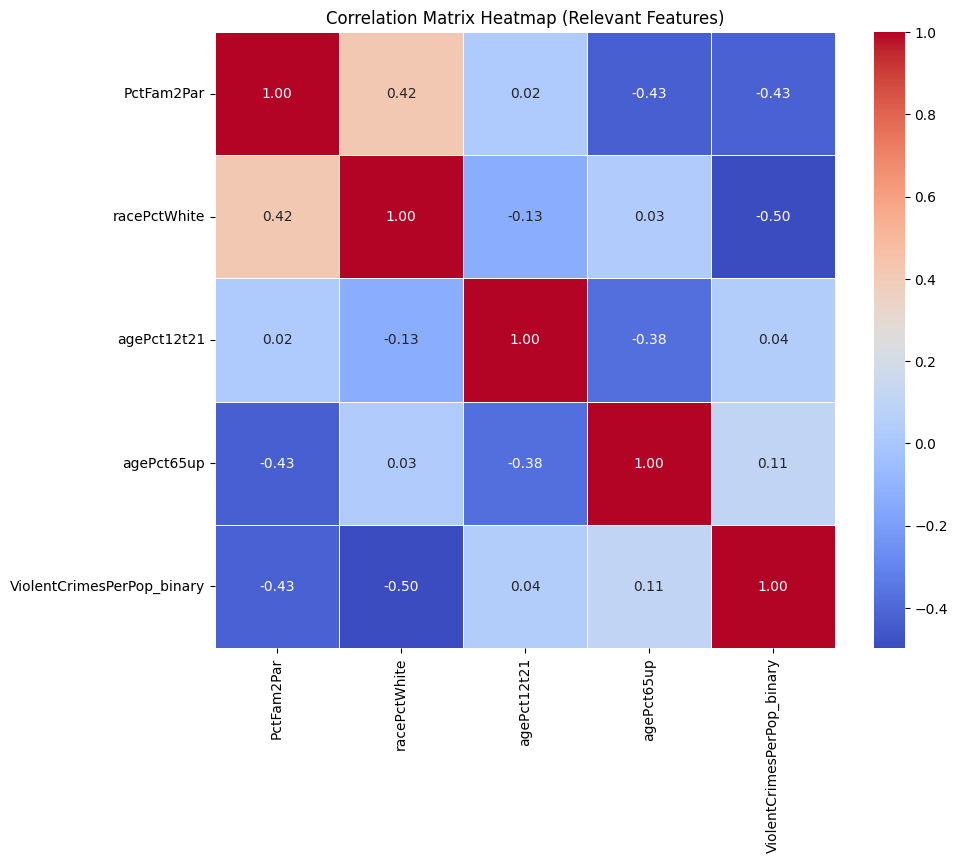

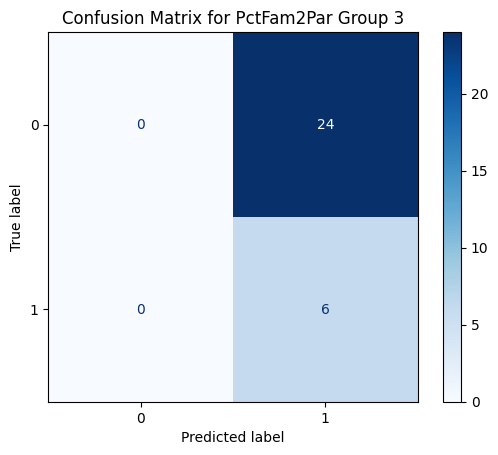

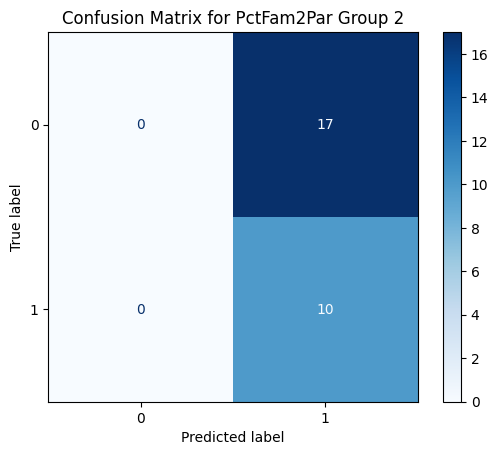

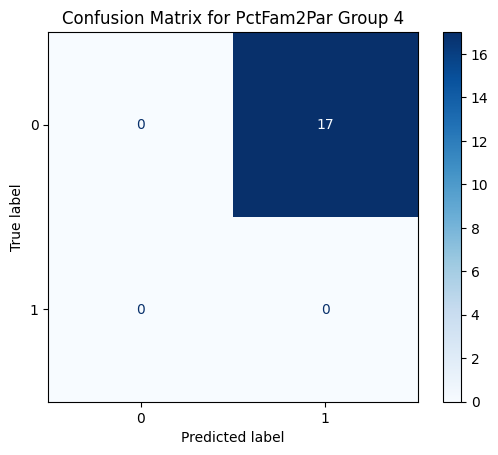

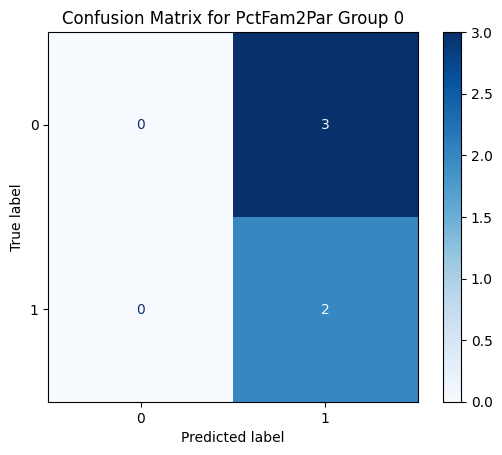

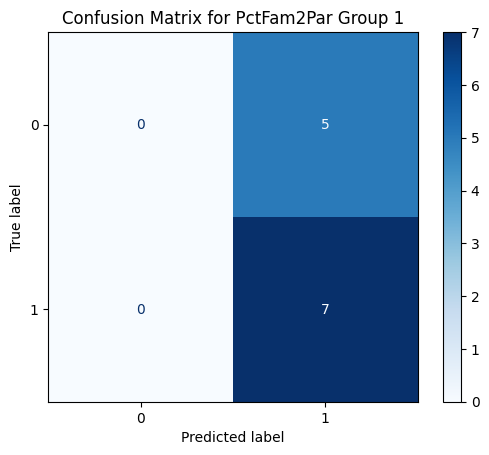

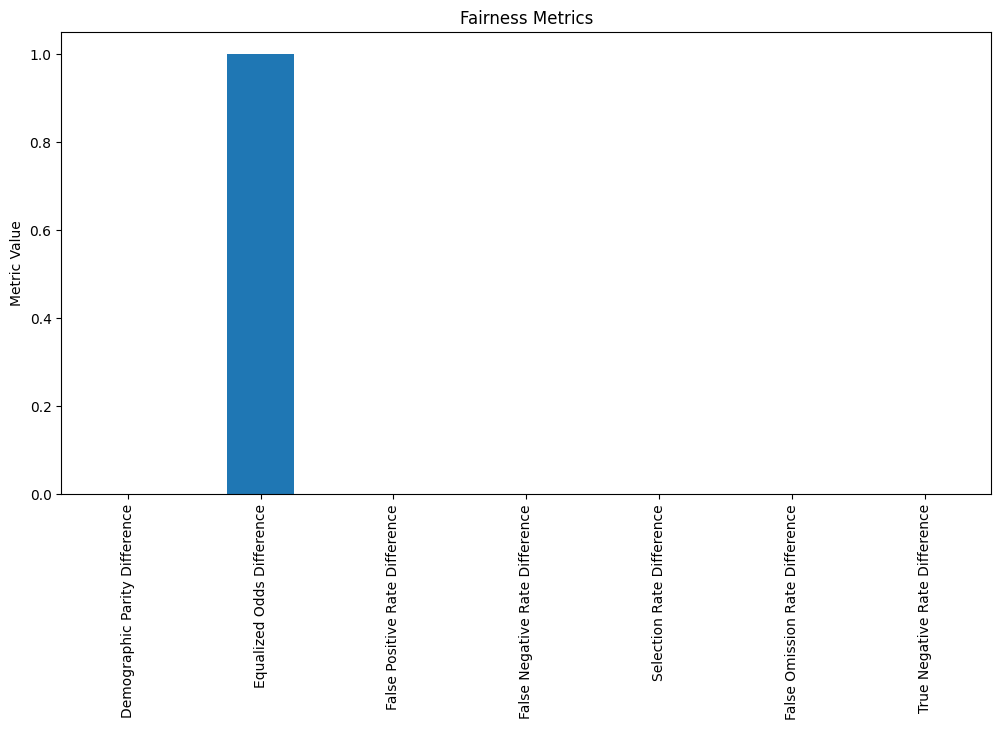

In [7]:
# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': for_diff,
    'True Negative Rate Difference': tnr_diff
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Create heatmap of correlation matrix for relevant features
relevant_features = ['PctFam2Par', 'racePctWhite', 'agePct12t21', 'agePct65up', 'ViolentCrimesPerPop_binary']
corr_matrix = data[relevant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Relevant Features)')
plt.show()

# Plot confusion matrix for PctFam2Par_bin
for PctFam2Par_group in df['PctFam2Par_bin'].unique():
    subset = df[df['PctFam2Par_bin'] == PctFam2Par_group]
    if len(subset['y_true'].unique()) > 1:
        cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1])
    else:
        cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1], sample_weight=np.ones(len(subset['y_true'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for PctFam2Par Group {PctFam2Par_group}')
    plt.show()

# Bar plot for fairness metrics
fairness_metrics = pd.Series(summary_metrics)
fairness_metrics.plot(kind='bar', figsize=(12, 6), title='Fairness Metrics')
plt.ylabel('Metric Value')
plt.show()
